In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
import scipy.stats as stats
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)

In [2]:
#Calculate mean, standard deviation and sharpe ratio
def mean_vol_sharpe(df,ann=12):
    mean = df.mean() * ann
    volatility = df.std() * np.sqrt(ann)
    sharpe_ratio = mean/volatility
    return pd.DataFrame({'mean': mean, 'volatility': volatility, 'sharpe_ratio': sharpe_ratio})

In [3]:
def stats_by_date(df, start_date, end_date):
    df = mean_vol_sharpe(df.loc[start_date:end_date])
    df.rename(columns={'mean':'mean '+start_date+'-'+end_date}, inplace=True)
    df.rename(columns={'volatility':'volatility '+start_date+'-'+end_date}, inplace=True)
    df.rename(columns={'sharpe_ratio':'sharpe_ratio '+start_date+'-'+end_date}, inplace=True)
    return df

In [4]:
def table_row(df, portfolio, annualize_factor=12):
    mean = df[portfolio].mean() * annualize_factor
    vol = df[portfolio].std() * np.sqrt(annualize_factor)
    sharpe_ratio = mean/vol
    skew = df[portfolio].skew() #unscaled
    corr = df[[portfolio, 'MKT', 'HML']].corr()
    corr_to_mkt = corr.loc[portfolio, 'MKT']
    corr_to_value = corr.loc[portfolio, 'HML']
    return [mean, vol, sharpe_ratio, skew, corr_to_mkt, corr_to_value]


#table1 = pd.DataFrame(index=['1927-2021', '1927-1993', '1994-2008', '2009-2021'],
    #columns=['mean ', 'vol ', 'sharpe_ratio ', 'skew ', 'corr_to_mkt ', 'corr_to_value', ])

# table1.loc['1927-2021', :] = table_row(df_mom_size.loc['1927':'2020',:], portfolio='rx_mom_FF')
# table1.loc['1927-1993', :] = table_row(df_mom_size.loc['1927':'1993',:], portfolio='rx_mom_FF')
# table1.loc['1994-2008', :] = table_row(df_mom_size.loc['1994':'2008',:], portfolio='rx_mom_FF')
# table1.loc['2009-2021', :] = table_row(df_mom_size.loc['2009':'2020',:], portfolio='rx_mom_FF')
# table1.style.set_caption('Solution Table 1: Momentum performance over time.')

# Homework #6

## 2. Investigating Momentum

### 2.1 . Is momentum still profitable?
The excess returns of lucrative trading strategies often disappear once the strategy is well-known. The first widely-cited paper on momentum was published in 1993. Have momentum returns or risk changed since then? The AQR case takes place at the end of 2008. Have momentum returns changed in 2009-2022?
Investigate by filling out the summary statistics below for the full-sample and three sub-samples.


### 2.1 (a)  Using the data provided, fill in Table 1 with the appropriate stats for $ \tilde{r}^{mom:FF} $

In [5]:
df_factors = pd.read_excel('momentum_data.xlsx', 1, index_col=0)
df_mom = pd.read_excel('momentum_data.xlsx', 2, index_col=0)
df_momentum = pd.read_excel('momentum_data.xlsx', 3, index_col=0)
df_mom_size = pd.read_excel('momentum_data.xlsx', 4, index_col=0)
rf = pd.read_excel('momentum_data.xlsx', 5, index_col=0)
df_mom_size = df_mom_size.join(df_factors)
df_mom_size = df_mom_size.join(rf)

In [6]:
df_mom_size['FF'] = pd.DataFrame(0.5*(df_mom_size['BIG HiPRIOR']+df_mom_size['SMALL HiPRIOR'])-0.5*(df_mom_size['BIG LoPRIOR']+df_mom_size['SMALL LoPRIOR']), columns=['fama'])


In [7]:
table1 = pd.DataFrame(index=['1927-2022', '1927-1993', '1994-2008', '2009-2022'],
    columns=['mean ', 'vol ', 'sharpe_ratio ', 'skew ', 'corr_to_mkt ', 'corr_to_value', ])
table1.loc['1927-2022', :] = table_row(df_mom_size.loc['1927':'2022',:], portfolio='FF')
table1.loc['1927-1993', :] = table_row(df_mom_size.loc['1927':'1993',:], portfolio='FF')
table1.loc['1994-2008', :] = table_row(df_mom_size.loc['1994':'2008',:], portfolio='FF')
table1.loc['2009-2022', :] = table_row(df_mom_size.loc['2009':'2022',:], portfolio='FF')
table1.style.set_caption('Solution Table 1: Momentum performance over time.')

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_value
1927-2022,0.0772,0.1626,0.4749,-3.0157,-0.3448,-0.4176
1927-1993,0.0901,0.1600,0.5630,-3.8093,-0.3625,-0.4949
1994-2008,0.1043,0.1755,0.5943,-0.5824,-0.2345,-0.1307
2009-2022,-0.0149,0.1593,-0.0932,-2.8113,-0.3779,-0.3851


### 2.1 (b) Has momentum changed much over time, as seen through these subsample statistics?

### Ans: Yes, momentum has changed over time as we see that mean has gone into negative territory in 2009-2022. This can be attributed to the huge bull run since the crisis in 2008. Also, the correlation to the market has gone down in 2009-2022 compared to 1994-2008.
### Furthermore, the sharpe ratio has fallen sharply in 2009-2022 compared to all historical periods.
### Correlation to the market and HML has stayed more or less the same, with the 1994-2008 correlation to HML being lower than the other periods.

### 2.1 (c) Does this data support AQR’s argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs—would there still be evidence here that momentum is valuable?

#### Yes the correlations to MKT and HML, the two popular portfolio factors is quite negative in the most recent period as well. Even if mean returns to momentum are near zero due to transaction costs, the negative correlation to the market and HML would still be valuable for portfolio allocation and optimization activities.


### 2.2 The case is about whether a long-only implementation of momentum is valuable.


Construct your own long-only implementation:,

$$ \tilde{r}^{momU:FF} = \frac{1}{2} \left( r^{momBU} + r^{momSU} \right) - r^f $$

Note that this is following the FF approach of treating big and small stocks separately. This
would be very similar to a scaled version of,

$$ \tilde{r}^{momU} = \frac{1}{3} \left( r^{mom(8)} + r^{mom(9)} + r^{mom(10)} \right) - r^f $$

For the question below, use the FF-style, $\tilde{r}^{momU:FF}_t$.

(a) Fill out Table 2 for the data in the period 1994-2022.

In [15]:
df_mom_size['FF_long'] = pd.DataFrame(0.5*(df_mom_size['BIG HiPRIOR']+df_mom_size['SMALL HiPRIOR'])-df_mom_size['RF'], columns=['fama_long'])
df_mom_size['FF_long']

Date
1927-01-31   -0.0005
1927-02-28    0.0473
1927-03-31   -0.0020
1927-04-30    0.0232
1927-05-31    0.0670
               ...  
2022-05-31    0.0062
2022-06-30   -0.0880
2022-07-31    0.0914
2022-08-31   -0.0084
2022-09-30   -0.0828
Name: FF_long, Length: 1149, dtype: float64

In [9]:
table2 = pd.DataFrame(index=['long_short', 'long_only'],
    columns=['mean ', 'vol ', 'sharpe_ratio ', 'skew ', 'corr_to_mkt ', 'corr_to_value', ])

table2.loc['long_short', :] = table_row(df_mom_size['1994':], portfolio='FF')
table2.loc['long_only', :] = table_row(df_mom_size['1994':], portfolio='FF_long')
table2.style.set_caption('Solution Table 2: Long-only momentum performance.')

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_value
long_short,0.0473,0.1686,0.2807,-1.4337,-0.3061,-0.2385
long_only,0.1128,0.1789,0.6304,-0.4829,0.9035,-0.1547


### 2.2 (b) Is long-only momentum as attractive as long-short momentum with respect to mean, volatility, and Sharpe Ratio?

Long Only momentum has a higher Mean and Sharpe Ratio compared to Long Short momentum. However, the volatility is higher for Long Only momentum compared to Long Short momentum.

### 2.2 (c) Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?

No, long-only momentum has a very high correlation to the market. But it still has a negative correlation to the value factor.

### 2.2 (d) Show a plot of the cumulative product of $1 + \tilde{r}^{mom:FF}$ and $1 + \tilde{r}^{momU:FF}$ over the 2006-2021 subsample.

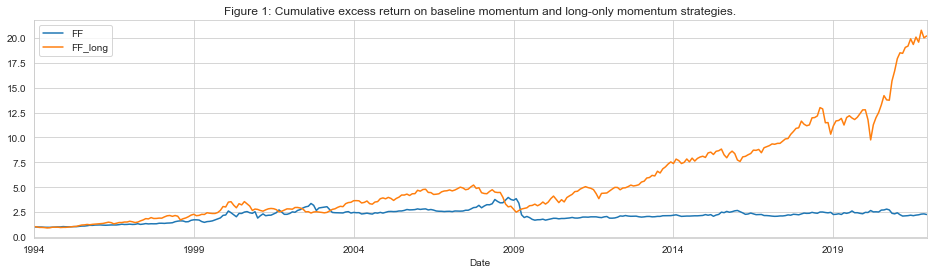

In [10]:
sns.set_style("whitegrid")
(df_mom_size.loc['1994':'2021', 'FF'] + 1).cumprod().plot(figsize=(16,4))
(df_mom_size.loc['1994':'2021', 'FF_long'] + 1).cumprod().plot(figsize=(16,4))
plt.title('Figure 1: Cumulative excess return on baseline momentum and long-only momentum strategies.')
plt.legend();

### 2.3. Is momentum just data mining, or is it a robust strategy?

Assess how sensitive the threshold for the “winners” and “losers” is in the results. Specifically, we compare three constructions:
 - long the top 1 decile and short the bottom 1 deciles
 $$ \tilde{r}^{momD1} = r^{mom(10)} - r^{mom(1)} $$
 - long the top 3 deciles and short the bottom 3 deciles
 $$ \tilde{r}^{momD3} = \frac{1}{3}\sum_{k=8}^{10} r^{mom(k)} - \frac{1}{3}\sum_{k=1}^{3} r^{mom(k)}$$
 - long the top 5 deciles and short the bottom 5 deciles
 $$ \tilde{r}^{momD5} = \frac{1}{5}\sum_{k=6}^{10} r^{mom(k)} - \frac{1}{5}\sum_{k=1}^{5} r^{mom(k)}$$

(a) Compare all three constructions, (in the full-sample period,) by filling out the stats in the
table below for the period 1994-2021.

In [11]:
df_momentum['rx_mom_D1'] = df_momentum['Hi PRIOR'] - df_momentum['Lo PRIOR']
table3 = pd.DataFrame(columns=['mean ', 'vol ', 'sharpe_ratio ', 'skew ', 'corr_to_mkt ', 'corr_to_value', ])

df = df_mom_size.join(df_momentum, rsuffix='momentum_')
df['rx_mom_D3'] = (1/3 * (df['PRIOR 8'] + df['PRIOR 9'] + df['Hi PRIOR']) -\
                1/3 * (df['Lo PRIOR'] + df['PRIOR 2'] + df['PRIOR 3']))
df['rx_mom_D5'] = (1/5 * (df['PRIOR 6'] + df['PRIOR 7'] + df['PRIOR 8'] + df['PRIOR 9'] + df['Hi PRIOR']) -\
                1/5 * (df['Lo PRIOR'] + df['PRIOR 2'] + df['PRIOR 3'] + df['PRIOR 4'] + df['PRIOR 5']))
table3.loc['rx_mom_D1', :] = table_row(df['1994':], portfolio='rx_mom_D1')
table3.loc['rx_mom_D3', :] = table_row(df['1994':], portfolio='rx_mom_D3')
table3.loc['rx_mom_D5', :] = table_row(df['1994':], portfolio='rx_mom_D5')

table3.style.set_caption('Table 3: Robustness of momentum construction.')

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_value
rx_mom_D1,0.0794,0.2980,0.2665,-1.3236,-0.3356,-0.2364
rx_mom_D3,0.0342,0.1926,0.1776,-1.3554,-0.3654,-0.2299
rx_mom_D5,0.0180,0.1340,0.1345,-1.4354,-0.3579,-0.2275


#### (b) Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?

Ans: The more extreme the cutoof for the winners the higher is the mean return. But the downside is that we expect higher volatility.

#### (c) Should AQR’s retail product consider using a 1-decile or 5-decile construction?

Ans: AQR may choose either of these options if they have a speicific investment theory. For instance, if they go with the 1-decile cutoff, they will be dealing with very high volatity (i.e Tail Risk) on their portfolio due to individual stocks, but higher mean returns. On the other hand, if they choose the 5-decile construction, they will be dealing with costly transaction costs in maintaing the portfolio. As per the Case Study, we know that AQR choose the middle route.

#### (d) Does $\tilde{r}^{momD3}$ have similar stats to the Fama-French construction in (1). Recall that construction is also a 3-decile, long-short construction, but it is segmented for small and large stocks. Compare the middle row of Table 3 with the top row of Table 2.

#### The FAMA-Frech use the Size factor as well to construct the momentum strategy. This probably contributes to the higher mean and lower Sharpe Ratio of the Fama-French construction compared to the 3-decile construction.

In [12]:
table3[1:2].style.set_caption('Table 3: Robustness of momentum construction.')

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_value
rx_mom_D3,0.0342,0.1926,0.1776,-1.3554,-0.3654,-0.2299


In [13]:
table2[:1].style.set_caption('Solution Table 2: Long-only momentum performance.')

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_value
long_short,0.0473,0.1686,0.2807,-1.4337,-0.3061,-0.2385


#### 4. Does implementing momentum require trading lots of small stocks—thus causing even larger trading costs?

For regulatory and liquidity reasons, AQR is particularly interested in using larger stocks for their momentum baskets. (Though they will launch one product that focuses on medium-sized stocks.)

Use the data provided on both small-stock “winners”, $r^{momSU}$, and small-stock “losers”, $r^{momSD}$, to construct a small-stock momentum portfolio,
 $$ \tilde{r}^{momS} = r^{momSU} - r^{momSD} $$
 
Similarly, use the data provided to construct a big-stock momentum portfolio,
 $$ \tilde{r}^{momB} = r^{momBU} - r^{momBD} $$

(a) Fill out Table 4 over the sample 1994-2022.

In [14]:
df['rx_mom_S'] = df['SMALL HiPRIOR'] - df['SMALL LoPRIOR']
df['rx_mom_B'] = df['BIG HiPRIOR'] - df['BIG LoPRIOR']
table4 = pd.DataFrame(columns=['mean ', 'vol ', 'sharpe_ratio ', 'skew ', 'corr_to_mkt ','corr_to_v'])
table4.loc['FF', :] = table_row(df['1994':], portfolio='FF')
table4.loc['rx_mom_S', :] = table_row(df['1994':], portfolio='rx_mom_S')
table4.loc['rx_mom_B', :] = table_row(df['1994':], portfolio='rx_mom_B')
table4.style.set_caption('Table 4: Small stock momentum performance.')

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_v
FF,0.0473,0.1686,0.2807,-1.4337,-0.3061,-0.2385
rx_mom_S,0.0627,0.1716,0.3656,-1.7501,-0.3069,-0.1647
rx_mom_B,0.0319,0.1819,0.1755,-0.8576,-0.2780,-0.2869


(b) Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?

It seems that the small stocks are actually driving the momentum strategy. Small momentum have almost double the mean return and Sharpe Ratio at the same volatility as the big momentum strategy. The large stocks do not seem to deliver excess returns at comparable risk.

## 3. In conclusion, what is your assessment of the AQR retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?

- Our assessment of the AQR retail  product would be that it is incomplete. In all the analysis conducted today, we have assets on the short side as well. Whereas, the AQR product is only long the top 3 momentum deciles. We understand that regulations are preventing them from shorting the bottom 3 momentum deciles. But we would suggest that they should consider adding a short component to their product. This will help them capture the downside risk as well. 
- Also, they should consider adding the small stocks to their product as well. This will help them capture the momentum in small stocks as well.